# **Project 3 - Reinforcement Learning**






## 🌞 Mission: Find a secret Location in Trondheim where SkyNets servers are located

📊 **High-level goal:**

Train an agent (the “learner”) to interact with given environment and learn from it, so it can maximize its cumulative rewards over time.




*   **Environment:**
     *   The environment **is already created** and set up for you with the help of
"gym" library.
     *   The agent is interacting with a simulated environment, which has states, accepts actions, and returns rewards. The environment resets at the beginning of each episode, and the agent takes actions within it, receiving feedback in the form of rewards.
*   **Q-table:**
     *   This table stores information about the "quality" of actions in different states.
     *   The goal of the agent is to update the Q-table over time to estimate the value of taking different actions in various states.
     *   You will initialize and learn Q-table in this project.


## Feedback
Please give detalied feedback if there is something obviously wrong. I dont need for stylistic or small errors :)

## 📮 Imports:

In [97]:
# import libraries
import numpy as np
import matplotlib.pyplot as plt
import imageio.v3 as iio
import random
import os

# note: make sure to install necessary libraries like imageio, gym etc.

In [98]:
# import gym stuff
import gym
from gym import error, spaces, utils
from gym.utils import seeding
from gym.spaces import Discrete, MultiDiscrete

### Utility functions are provided for you:


*   one_hot_decode
*   one_hot_encode
*   make_2d
*   make_3d
*   read_png_file
*   is_valid_idx
*   flatten_observation
*   is_valid_idx
*   flatten_observation
*   make_2d_observation
*   swap_values

In [99]:
def one_hot_decode(label_3D):
  """
  Converts back from one-hot encoded format (label_3D)
  to original class labels for each pixel (2D)
  """
  return np.argmax(label_3D, axis=-1)

def one_hot_encode(label_2D, label_values):
    """
    Converts a segmentation image label array (label_2D) to one-hot format
    by replacing each pixel value with a vector of length num_classes
    # Arguments
        label_2D: The 2D array segmentation image label
        label_values: an RGB array of classes (num_classes, 3)

    # Returns
        A 3D array with the same width and height as the input,
        but with a depth size of num_classes (for each pixel)

        Each class gets its own encoding for every pixel in the image.
        Encodings are then stacked along new axis which is number of classes
    """
    semantic_map = []
    for colour in label_values:
        equality = np.equal(label_2D, colour)
        class_map = np.all(equality, axis=-1)
        semantic_map.append(class_map)
    semantic_map = np.stack(semantic_map, axis=-1)

    return semantic_map

def make_2d(map_3d=None, palette_array=None):
    """
    Converts RGB images to images with number of class as value at [i,j]

    map_3d: 3D RGB image (H, W, n_ch = 3)
    palette_array: an RGB array of classes (num_classes, 3)

    Result: 2D structure where each "pixel" in the image
    has a class number instead of RGB color
    """
    # here we make 3D representation, 3rd dimension has one-hot encoded classes
    replaced_image_onehot = one_hot_encode(
        map_3d.astype(np.uint8), palette_array) # size (H, W, num_classes)
    # we create 2D representation, where every pixel has the value of its class
    return one_hot_decode(replaced_image_onehot) # size (H, W) - 2D

def make_3d(map_2d=None, palette_array=None):
    """
    Convert a 2d img to 3d
    Convert a 2D image where each pixel represents a class label
    into a 3D image where each class label is represented
    by its corresponding RGB color from the palette_array.
    Creates colorized 3D image from the original 2D class map

    map_2d: array of class labels, size (H, W)
    palette_array: an RGB array of classes (num_classes, 3)

    Result: RGB image (H, W, 3)
    """
    return palette_array[map_2d.astype(np.uint8)]


def read_png_file(image_path, printDebug = True):
    """
    read a png file and returns it as a 3D numpy array
    """
    original_image_matrix = iio.imread(image_path)

    if original_image_matrix.ndim > 2 and original_image_matrix.shape[-1] > 3:
        if printDebug:
            print(f'image has more than 3 channels, only first 3 channels are used there are {original_image_matrix.shape} channels')
        original_image_matrix = original_image_matrix[:, :, :3]
    return original_image_matrix

def is_valid_idx(image_2D, selected_idx):
    """
    Checks if a given index is within the valid range of a 2D array

    if selected_idx is valid in image_2D
    selected_idx = [i,j]
    image_2D = [h,w]
      """
    if selected_idx[0] < 0 or selected_idx[1] < 0:
        return False
    if selected_idx[0] < image_2D.shape[0]:
        if selected_idx[1] < image_2D.shape[1]:
            return True
    return False

def flatten_observation(observation_arr):
    """
    Converts/flattens a multi-dimensional array into a 1D array
    """
    return observation_arr.flatten


def make_2d_observation(observation_flattened, observation_arr_shape):
    """
    Converts flattened array into shape observation_arr_shape
    """
    return observation_flattened.reshape(observation_arr_shape.shape)

def swap_values(arr, value1, value2):
    """
    Swaps occurencies of two specific values (value1 and value2)
    within a 2D NumPy array (arr).

    arr: A 2D NumPy array where we want to swap the values
    value1: the first value that we want to swap with value2
    value2: the second value that we want to swap with value1

    Returns: 2D array with swapped values
    """

    # Ensure the values are integers
    value1, value2 = int(value1), int(value2)

    # Step 1: Find the first position of value1 and change it to value2
    pos_value1 = np.argwhere(arr == value1) # returns 2D array
    if pos_value1.size > 0:
        arr[pos_value1[0][0], pos_value1[0][1]] = value2

    # Step 2: Get all positions of value2
    pos_value2 = np.argwhere(arr == value2) # returns 2D array

    # Step 3: Randomly select a position of value2 that is not the original value1's position
    if len(pos_value2) > 1:
        # filter out the position of former value1 (pos_value1) which now also contains value2
        pos_value2 = pos_value2[np.all(pos_value2 != pos_value1[0], axis=1)]
        if pos_value2.size > 0:
            random_pos_value2 = pos_value2[np.random.choice(len(pos_value2))]
            arr[random_pos_value2[0], random_pos_value2[1]] = value1

    return arr

### Environment class with necessary functions - provided for you:


*   constructor __init__
*   step
*   reset
*   get_1d_state
*   render
*   close


In [312]:
class TrondheimEnv(gym.Env):
    metadata = {'render.modes': ['human']}

    def __init__(self, conf):
        """
        Every environment should be derived from gym.Env and at least contain
        variables observation_space and action_space specifying the type of possible
        observations and actions using spaces.Box or spaces.Discrete.

        Example:
        >>> EnvTest = TrondheimEnv()
        >>> EnvTest.observation_space=spaces.Box(low=-1, high=1, shape=(3,4))
        >>> EnvTest.action_space=spaces.Discrete(2)
        """

        self.manual_mode = True  # Flag to control printouts

        # action definition:
        number_action = 4
        self.action_space = Discrete(number_action)

        self.env_image_path = conf['env_image_path']
        self.number_removable_locations = conf['number_removable_locations']

        self.pallete = np.array([[0, 0, 255],    # Blue:0:Water
                            [255, 255, 0],  # Yellow:1:Start
                            [0, 255, 0],    # Green:2:Land
                            [255, 0, 0],    # Red:3:BusLane
                            [128, 0, 128],  # Purple:4:BusStop
                            [0,   0,   0],  # Black:5:Secret Location
                            [128, 128, 0]], # Olive:6:Final Location
                           dtype=np.uint8)

        self.neighbours = np.array([[-1,0],[0,-1],[1,0],[0,1]]) # up, left, down, right
        self.not_allowed_area = [0] # water
        self.normal_land_class = 2 # land
        self.neutral_area = [self.normal_land_class,3] # land and BusLane
        self.start_class = 1 # start
        self.busstop_class = 4 # bus stop
        self.secret_location_class = 5 # secret location
        self.final_location_class = 6 # final location (2)

        # does agent die when enter not_allowed_area
        self.dead_allowed = conf['dead_allowed']
        # does shops closed after the first purchase
        self.remove_after_location_found = conf['remove_after_location_found']
        # should we start at different place each time
        self.start_random = conf['start_random']

        # read RGB image into a 3D numpy array
        img_3d = read_png_file(self.env_image_path, printDebug = False)

        # convert RGB image into 2D semantic class representation
        img_2d = make_2d(map_3d=img_3d,
                         palette_array=self.pallete)

        # the current state of the environment
        self.observation = img_2d # initial observation - 2D semantic class
        # copy of the environment's initial state before any actions have been taken
        self.initial_observation = img_2d.copy()

        max_observation_value = np.max(img_2d)
        # assert isinstance(max_observation_value, int)
        # can be used, not needed for this implementation
        # observation space is a gym object (MultiDiscrete), like numpy array. It can be sampled
        observation_space = np.full_like(img_2d,
                                         fill_value=max_observation_value)
        self.observation_space = MultiDiscrete(observation_space)

        # rewards
        self.reward = 0

        # done
        self.done = False

        # terminated
        self.terminated = False




    def step(self, action):
        """
        This method is the primary interface between environment and agent.

        Parameters:
            action: int
                    the index of the respective action (if action space is discrete)

        Returns:
            output: (array, float, bool, info)
                    information provided by the environment about its current state:
                    (observation, reward, done)

                    self.observation: The updated state of the environment (2D)
                    reward: Reward agent received for the action in this step (Int)
                    terminated: indicate if the episode has ended (Bool)
                    info: Additional information (not used currently)

        """
        obs = self.observation # 2D array of semantic class image representation
        terminated = False
        truncated = False
        info = None

        # just start and see where it goes
        start_idx = np.argwhere(obs == self.start_class)[0]
        # action is: 0:up, 1:left, 2:down, 3:right
        next_idx = start_idx + self.neighbours[action]
        reward = self.reward
        if self.manual_mode:
          print('Next step towards: ')

        if not is_valid_idx(image_2D=obs, selected_idx=next_idx):
            next_idx = start_idx
            if self.manual_mode:
                print('Hey there, you cannot escape outside of the environment')

        # now decide what happens next

        if obs[tuple(next_idx)] == self.normal_land_class:
            if self.manual_mode:
                print('Green Land class area')
            reward = -1
        # check if it is a non allowed area
        if obs[tuple(next_idx)] in self.not_allowed_area:
            if self.manual_mode:
                print('The move is not allowed')
            if self.dead_allowed:
                # penalize the agent if allowed to die. Terminate
                reward = -1000
                terminated = True
            else:
                # if NOT allowed to die, reset the next position to current one - prevent the move
                next_idx = start_idx


        # if the player is in bus stup
        elif obs[tuple(next_idx)] == self.busstop_class:
            if self.manual_mode:
                print('A bus stop')

            # get the bus stop that is not the next step
            bus_stop_indices = np.argwhere(obs == self.busstop_class)
            # flip the next state to the other side of the stop
            if np.array_equal(next_idx, bus_stop_indices[0]):
                # teleport the agent from bus stop 0 to bus stop 1
                next_idx = bus_stop_indices[1]
                # reward = 100
            else:
                # teleport the agent from bus stop 1 to bus stop 0
                next_idx = bus_stop_indices[0]
                # reward = -100

        # if it is Secret Location
        elif obs[tuple(next_idx)] == self.secret_location_class:
            if self.manual_mode:
                print('Central Source Secret Location')
            reward = 300
            # close the shop (remove from the map)
            if self.remove_after_location_found:
                self.initial_observation[tuple(next_idx)] = self.normal_land_class
                self.number_removed_shop += 1
                reward = 9000

        # and the Final Location
        elif obs[tuple(next_idx)] == self.final_location_class:
            if self.manual_mode:
                print('Final Location - well done!')
                print('You have discovered the Final Location of AI center in Trondheim')
            reward = 200


        # now we need to change the observation space
        # i.e. update the environment’s state to reflect the agent's movement

        # if agent’s current position was initial start position
        if self.initial_observation[tuple(start_idx)] == self.start_class:
            # if true, update observation - mark the start position as neutral area
            self.observation[tuple(start_idx)] = self.normal_land_class
        else:
            # if current position not the initial start one
            # restores position in self.observation to its original value from self.initial_observation
            # re-color the observation as where you were if not start position
            self.observation[tuple(start_idx)] = self.initial_observation[tuple(start_idx)]

        # sets the new position of the agent as the next start position
        self.observation[tuple(next_idx)] = self.start_class

        return self.observation, reward, terminated, info


    def reset(self):
        """
        This method resets the environment to its initial values.

        Returns:
            observation:    array
                            the initial state of the environment
        """
        self.number_removed_shop = 0

        img_3d = read_png_file(self.env_image_path, printDebug = False)
        img_2d = make_2d(map_3d=img_3d,
                         palette_array=self.pallete)

        if self.start_random:
          # we need to move the start to another place
          img_2d = swap_values(arr=img_2d,
                               value1=1,
                               value2=2)

        self.observation = img_2d
        self.initial_observation = img_2d.copy()

        max_observation_value = np.max(img_2d)
        observation_space = np.full_like(img_2d,
                                         fill_value=max_observation_value)
        self.observation_space = MultiDiscrete(observation_space)

        # rewards
        self.reward = 0

        # done
        self.done = False

        # terminated
        self.terminated = False

        return self.observation


    def get_1d_state(self):
        """
        This function returns state as 1d observation
        """
        max_x = self.observation.shape[0]
        max_y = self.observation.shape[1]

        start_idx = np.argwhere(
            self.observation == self.start_class)[0]
        state_number = (
            start_idx[0] * max_x) + start_idx[1]
        state_number = (self.number_removed_shop * max_x * max_y) + state_number
        return state_number

    def render(self, mode='human', close=False):
        """
        This methods provides the option to render the environment's behavior to a
        window which should be readable to the human eye if mode is set to 'human'.
        """
        render_ready_arr = make_3d(map_2d=self.observation,
                                   palette_array=self.pallete)
        plt.imshow(render_ready_arr)
        plt.show()
        plt.close()
        return render_ready_arr

    def close(self):
        """
        This method provides the user with the option to perform necessary
        cleanup.
        """
        img_3d = read_png_file(self.env_image_path)
        img_2d = make_2d(map_3d=img_3d,
                         palette_array=self.pallete)
        self.observation = img_2d
        self.initial_observation = img_2d.copy()


In [101]:
# let's make sure to create subfolder for our input images, if not already there
input_folder = 'input_images'
if not os.path.exists(input_folder):
    os.makedirs(input_folder)

# Configuring and loading the environment:

## 🔎📉  Let's first visualize our simple toy environment

In [102]:
# This is how you create a configuration for the environment
# Note: make sure that folder input_images is created
# Note 2: make sure you copy necessary input images there

env_config = {
    'env_image_path':'input_images/image_simple_1.png',
    'dead_allowed':False,
    'remove_after_location_found':False,
    'start_random':False,
    'number_removable_locations':0,
}


if not os.path.exists(env_config['env_image_path']):
  # make sure you have the folder and the image
  print(f"Error: The image path {env_config['env_image_path']} does not exist.")
else:
  # if everything fine, we create the environment
  tmp_env = TrondheimEnv(conf=env_config)
  print(f"Environment successfully created")

Environment successfully created


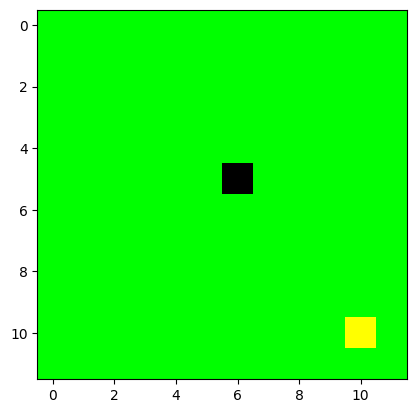

array([[[  0, 255,   0],
        [  0, 255,   0],
        [  0, 255,   0],
        [  0, 255,   0],
        [  0, 255,   0],
        [  0, 255,   0],
        [  0, 255,   0],
        [  0, 255,   0],
        [  0, 255,   0],
        [  0, 255,   0],
        [  0, 255,   0],
        [  0, 255,   0]],

       [[  0, 255,   0],
        [  0, 255,   0],
        [  0, 255,   0],
        [  0, 255,   0],
        [  0, 255,   0],
        [  0, 255,   0],
        [  0, 255,   0],
        [  0, 255,   0],
        [  0, 255,   0],
        [  0, 255,   0],
        [  0, 255,   0],
        [  0, 255,   0]],

       [[  0, 255,   0],
        [  0, 255,   0],
        [  0, 255,   0],
        [  0, 255,   0],
        [  0, 255,   0],
        [  0, 255,   0],
        [  0, 255,   0],
        [  0, 255,   0],
        [  0, 255,   0],
        [  0, 255,   0],
        [  0, 255,   0],
        [  0, 255,   0]],

       [[  0, 255,   0],
        [  0, 255,   0],
        [  0, 255,   0],
        [  0, 255, 

In [103]:
# visualize the environment. Yellow is where we are, Black is where we want to go
tmp_env.reset()
tmp_env.render()

Let's see how actions work:

In [104]:
action_dict = {
    'up':0,
    'left':1,
    'down':2,
    'right':3,
}

Next step towards: 
Green Land class area
Reward for action right is: 0


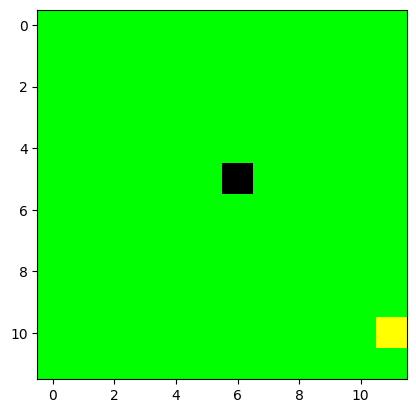

Observation space looks like this:
[[2 2 2 2 2 2 2 2 2 2 2 2]
 [2 2 2 2 2 2 2 2 2 2 2 2]
 [2 2 2 2 2 2 2 2 2 2 2 2]
 [2 2 2 2 2 2 2 2 2 2 2 2]
 [2 2 2 2 2 2 2 2 2 2 2 2]
 [2 2 2 2 2 2 5 2 2 2 2 2]
 [2 2 2 2 2 2 2 2 2 2 2 2]
 [2 2 2 2 2 2 2 2 2 2 2 2]
 [2 2 2 2 2 2 2 2 2 2 2 2]
 [2 2 2 2 2 2 2 2 2 2 2 2]
 [2 2 2 2 2 2 2 2 2 2 2 1]
 [2 2 2 2 2 2 2 2 2 2 2 2]]


(12, 12)

In [105]:
# select your action here
# you are encouraged to play further with this
my_action = 'right'

# now take a step through the environment by taking this action
obs, rew, term, info = tmp_env.step(action_dict[my_action])
print(f"Reward for action {my_action} is: {rew}")
tmp_env.render()

print(f"Observation space looks like this:\n{obs}")
obs.shape

# 🧠 **Your Assignments**

# 1️⃣ Assignment 1: Q-learning with simple toy environment

## 🐣 Let's learn how to do this in a simple environment


*   Task 1: Initialize Q table
*   Task 2: Write necessary helper functions for Q-learning
*   Task 3: Play with Hyperparameters
*   Task 4: Train the agent using Q-learning
*   Task 5: Explain visual representation of environment after training

**Note**: Task 2, Task 3 and Task 4: you will use the same code you implemented for these in the Assignment 2.

In [106]:
# Environment is set up for you here
env_config = {
    'env_image_path':'input_images/image_simple_1.png',
    'dead_allowed':False,
    'remove_after_location_found':False,
    'start_random':False,
    'number_removable_locations':0,
}

if not os.path.exists(env_config['env_image_path']):
  # make sure you have the folder and the image
  print(f"Error: The image path {env_config['env_image_path']} does not exist.")
else:
  # if everything fine, we create the environment
  tmp_env = TrondheimEnv(conf=env_config)
  print(f"Environment successfully created")

Environment successfully created


### Task 1: Initialize Q table

In [107]:
# Task 1: Initialize Q table


# Tip: pay attention to the dimensions of Q table
# Tip: how many states the table have, how many actions

print(f"Observation space dimensions:  {tmp_env.observation_space.shape}")
print(f"Number of possible actions: {tmp_env.action_space.n}")

# YOUR CODE GOES HERE
num_states = 12*12
num_actions = 4
Q_test = np.zeros((num_states, num_actions))

#Q_test = np.random.uniform(low=0.0, high=0.01, size=(num_states, num_actions))
print(Q_test.shape)

Observation space dimensions:  (12, 12)
Number of possible actions: 4
(144, 4)


In [108]:
# take a look into initial Q table (randomized one)
print(f"Q table has this shape: {Q_test.shape}\n")

# you may want to print Q table, or parts of it, to get the vibe
print(Q_test[:10])
print(f"\n")
print(Q_test[135:])

Q table has this shape: (144, 4)

[[0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]]


[[0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]]


### Task 2: Write necessary helper functions for Q-learning

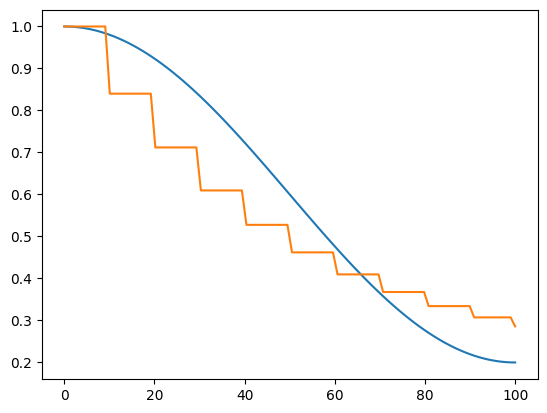

In [109]:
# Task 2: Write necessary helper functions for Q-learning
"""
TODO: write helper function to:
 update_explore_rate() - controls the balance between exploration and exploitation
 update_learning_rate() - controls how aggressively the agent updates its knowledge

 update_action() - uses the exploration rate to decide whether to take a
 random action (explore) or to act according to the learned Q-values (exploit)
"""


# Explore Rate Decay Function, Converges to MIN_EXPLORE_RATE
def update_explore_rate(episode, MIN_EXPLORE_RATE, initial_exploration_rate, stepsize=10, percentage_reduction=0.1):
    """
    Step decay of exploration rate
    return:
        float with new value of exploration rate
    """
    return (initial_exploration_rate-MIN_EXPLORE_RATE)*((1-percentage_reduction)**(episode//stepsize))+MIN_EXPLORE_RATE


# Learning Rate Decay Function, Converges to MIN_LEARNING_RATE
def update_learning_rate(episode, MIN_LEARNING_RATE, base_lr, total_episodes):
    """
    Cosine decay of learning rate
    return:
        float with new value of learning rate
    """
    cosine_decay_factor = 0.5 * (1 + np.cos(np.pi*(episode/total_episodes)))
    return MIN_LEARNING_RATE+(base_lr-MIN_LEARNING_RATE)*cosine_decay_factor


# returns an action based on current state, explore rate and Q table
def update_action(env: TrondheimEnv, state, explore_rate, Q):
    if np.random.random() < explore_rate:
        return env.action_space.sample()
    else:
        return np.argmax(Q[state])

x = np.linspace(0, 100, 100)
plt.plot(x, update_learning_rate(x, 0.2, 1, 100))
plt.plot(x, update_explore_rate(x, 0.2, 1, percentage_reduction=0.2))
plt.show()


### Task 3: Play with Hyperparameters

In [205]:
# Task 3: Play with Hyperparameters

# YOUR CODE GOES HERE: replace None with your values
GAMMA_test = 0.99
NUM_EPISODES_test = 10000
MIN_EXPLORE_RATE_test = 0.01
MIN_LEARNING_RATE_test = 0.01
STEP_SIZE_TEST = 144

## 🐤 Now use Q learning to learn the Q table
### Task 4: Train the agent using Q-learning

The Q-value update equation, also known as the Bellman equation, is as follows:

$Q(s, a) = Q(s, a) + α * [reward + γ * max(Q(s', a')) - Q(s, a)]$

Episode :0  Total_reward: 300  Explore rate: 1.0
Episode :500  Total_reward: 1507800  Explore rate: 0.608956006466161
Episode :1000  Total_reward: 6429900  Explore rate: 0.3723720178604969
Episode :1500  Total_reward: 13730100  Explore rate: 0.22923726936647232
Episode :2000  Total_reward: 22272600  Explore rate: 0.1426398781093821
Episode :2500  Total_reward: 31445400  Explore rate: 0.09024793100055946
Episode :3000  Total_reward: 41023800  Explore rate: 0.058550485130572864
Episode :3500  Total_reward: 50796300  Explore rate: 0.03937333806646733
Episode :4000  Total_reward: 60714300  Explore rate: 0.027771047742294684
Episode :4500  Total_reward: 70702800  Explore rate: 0.0207515917034791
Episode :5000  Total_reward: 80761800  Explore rate: 0.016504778211990458
Episode :5500  Total_reward: 90834900  Explore rate: 0.013935430283638282
Episode :6000  Total_reward: 100920000  Explore rate: 0.012380959198397956
Episode :6500  Total_reward: 111022200  Explore rate: 0.011440494760637689
Ep

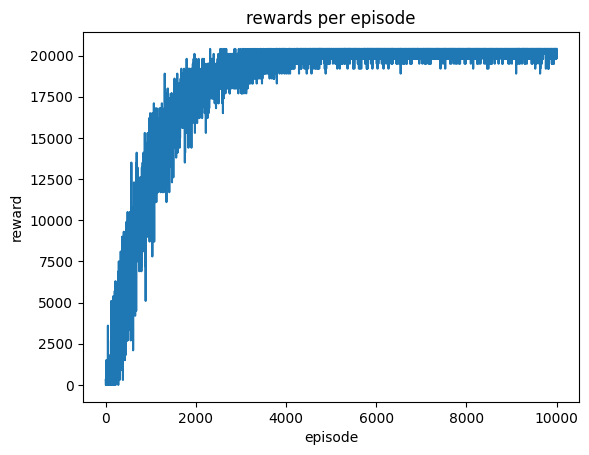

In [207]:
# Task 4: Train the agent using Q-learning
# you are free either to just write the code or create a function

# result of the training is:
#   updated Q table (Q_test)
#   total_reward
#   you are free to add others, if you will


tmp_env.manual_mode = False # disable printouts while training

# initialize some variables
Q_test = np.zeros((num_states, num_actions))
total_reward = 0
rewards_per_episode = []

for episode in range(NUM_EPISODES_test):
    explore_rate = update_explore_rate(episode, MIN_EXPLORE_RATE_test, 1, percentage_reduction=0.01)
    learning_rate = update_learning_rate(episode, MIN_LEARNING_RATE_test, base_lr=1, total_episodes=NUM_EPISODES_test)
    tmp_env.reset()
    state = tmp_env.get_1d_state()
    done = False
    reward_episode = 0

    for step in range(STEP_SIZE_TEST):
        if done:
            break

        action = update_action(tmp_env, state, explore_rate, Q_test)
        _, reward, done, _ = tmp_env.step(action)
        next_state = tmp_env.get_1d_state()
        reward_episode += reward
    
        best_next_action = np.argmax(Q_test[next_state])
        td_target = reward + GAMMA_test*Q_test[next_state][best_next_action]
        Q_test[state][action] = Q_test[state][action] + learning_rate*(td_target-Q_test[state][action])
        state = next_state

    rewards_per_episode.append(reward_episode)
    total_reward += reward_episode
  # Tip : print variables of interest, like episode, total_reward, explore_rate
    if (episode)%500==0:
        print(f"Episode :{episode}  Total_reward: {total_reward}  Explore rate: {explore_rate}")

# print("Final Q values: ", Q_test)

plt.plot(rewards_per_episode)
plt.title("rewards per episode")
plt.xlabel("episode")
plt.ylabel("reward")
plt.show()

In [194]:
Q_test

array([[    0.        ,     0.        ,     0.        ,     0.        ],
       [    0.        ,     0.        ,     0.        ,     0.        ],
       [    0.        ,     0.        ,     0.        ,     0.        ],
       [    0.        ,     0.        ,     0.        ,     0.        ],
       [    0.        ,     0.        ,   805.9754246 ,  8869.74864548],
       [ 3775.26525922,  3588.07219436,   836.71569593, 13655.87666129],
       [ 3746.60319819,  1515.44751253, 13986.22211636, 14178.51421219],
       [ 3853.34607691, 13684.29770682, 14329.71544207,  3822.7211612 ],
       [ 3822.72469986,  3781.59662418,  3861.33813629,  3784.49750737],
       [ 3784.49749675,  1561.87261431,  3822.72475495,  1561.87261359],
       [ 1561.87192456,  1577.64910537,  3781.8861146 ,  1544.32024755],
       [ 1544.32024755,  1561.87200281,     0.        ,     0.        ],
       [    0.        ,     0.        ,     0.        ,     0.        ],
       [    0.        ,     0.        ,     0.     

In [183]:
print(f"Total reward after training: {total_reward}, total Explore rate after training: {explore_rate}")

Total reward after training: 16653000, total Explore rate after training: 0.10002656139888759


## 🐥 Let's see this in action

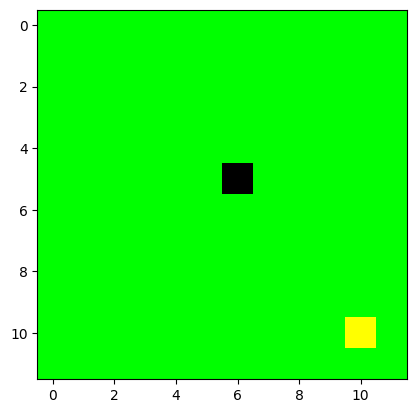

Next step towards: 
Green Land class area


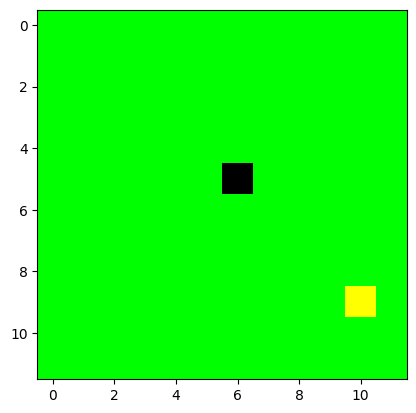

Next step towards: 
Green Land class area


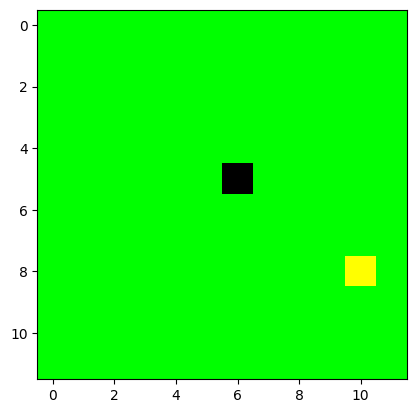

Next step towards: 
Green Land class area


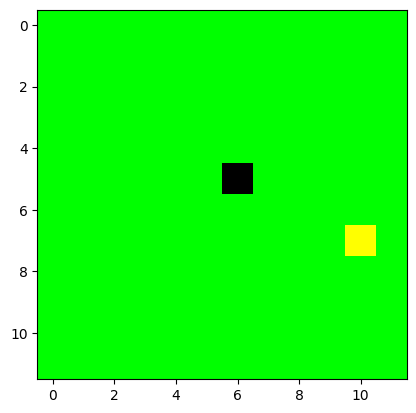

Next step towards: 
Green Land class area


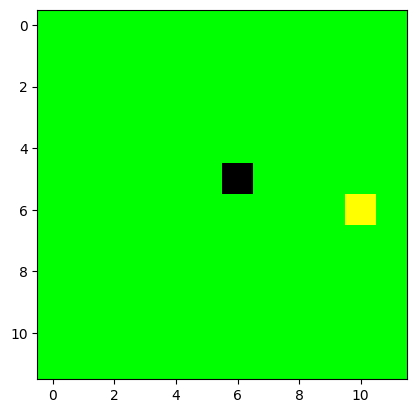

Next step towards: 
Green Land class area


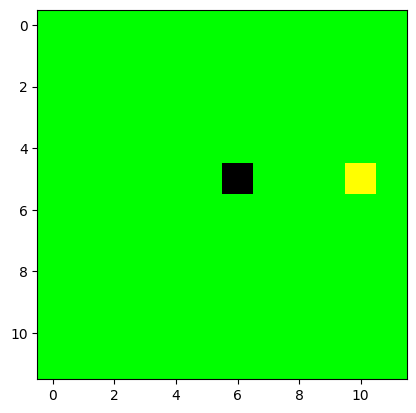

Next step towards: 
Green Land class area


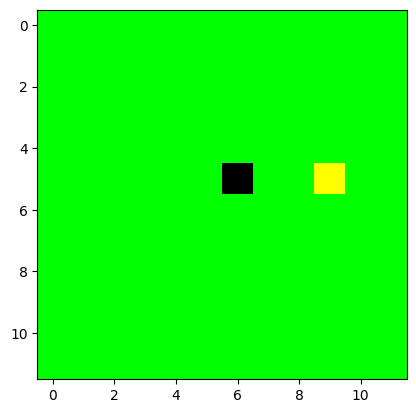

Next step towards: 
Green Land class area


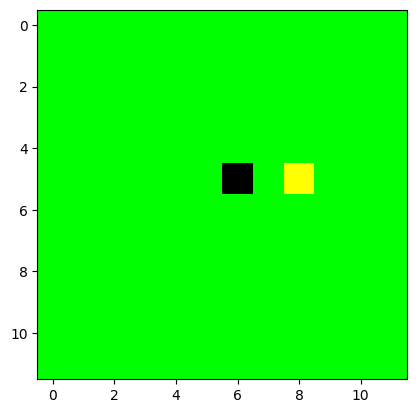

Next step towards: 
Green Land class area


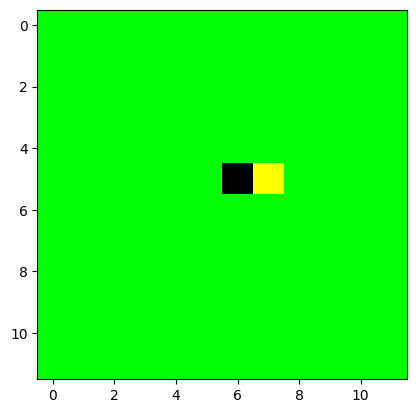

Next step towards: 
Central Source Secret Location


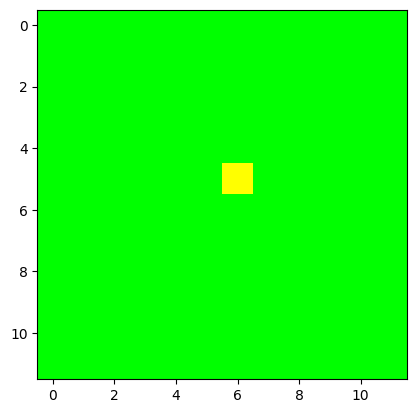

Next step towards: 
Green Land class area


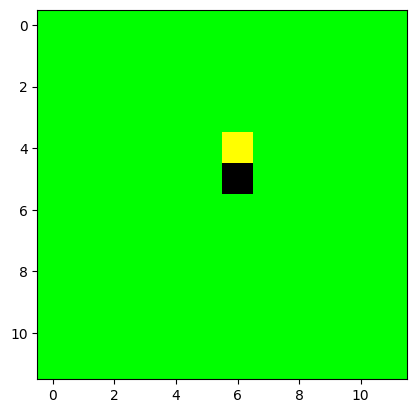

Next step towards: 
Green Land class area


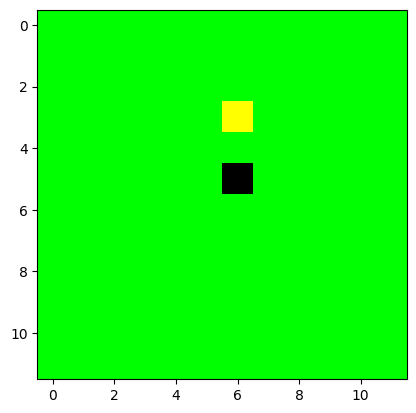

Next step towards: 
Green Land class area


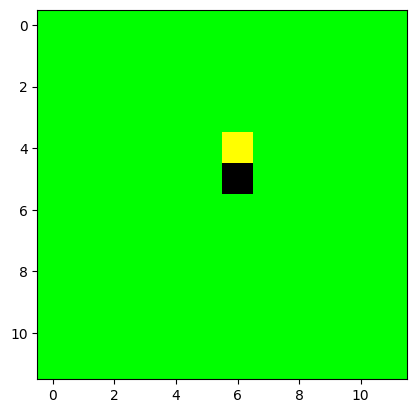

Next step towards: 
Central Source Secret Location


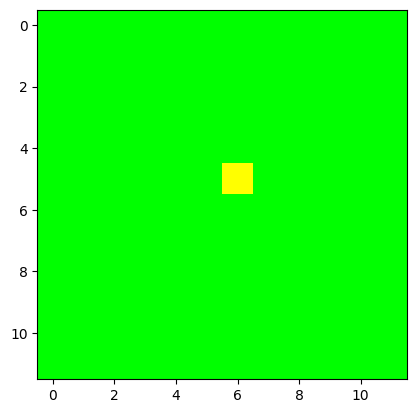

Next step towards: 
Green Land class area


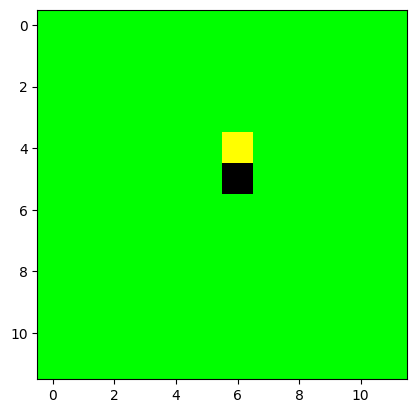

Next step towards: 
Central Source Secret Location


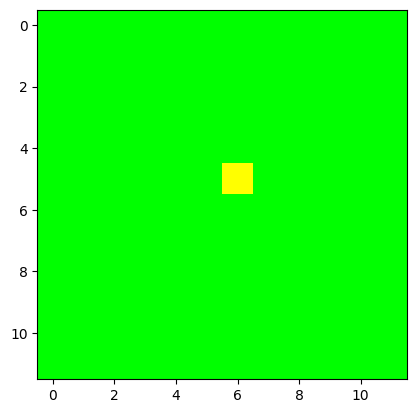

Next step towards: 
Green Land class area
Total_reward:  900


In [184]:
# now we show one episode
# yellow spot should be able to find black spot here

tmp_env.manual_mode = True # enable messages
STEP_SIZE_TEST_test = 16

observation = tmp_env.reset()
state_0 = tmp_env.get_1d_state()
total_reward = 0

for _ in range(STEP_SIZE_TEST_test):
    tmp_env.render()
    action = update_action(tmp_env, state_0, explore_rate, Q=Q_test)
    obv, reward, done, info = tmp_env.step(action)
    state_1 = tmp_env.get_1d_state()

    # No need to update the Q here
    state_0 = state_1

    total_reward += reward

print(f"Total_reward: ", total_reward)

In [185]:
# the shape of Q table (Q_test)
print(Q_test.shape)
print(f"Obs space dimensions :{tmp_env.observation_space.shape}")

(144, 4)
Obs space dimensions :(12, 12)


In [186]:
# print Q_table in "observation space" light
Q_test.argmax(axis=1).reshape(tmp_env.observation_space.shape)

array([[0, 3, 2, 2, 3, 2, 1, 1, 0, 2, 0, 0],
       [3, 3, 3, 2, 2, 2, 2, 2, 2, 2, 1, 1],
       [0, 2, 3, 2, 2, 2, 2, 2, 2, 2, 2, 2],
       [2, 2, 0, 3, 2, 2, 2, 1, 2, 1, 1, 1],
       [3, 3, 3, 2, 2, 2, 2, 1, 1, 1, 1, 1],
       [3, 3, 3, 3, 3, 3, 0, 1, 1, 1, 1, 1],
       [0, 3, 3, 3, 0, 0, 0, 0, 0, 0, 0, 0],
       [2, 0, 3, 3, 0, 0, 0, 0, 0, 0, 0, 0],
       [2, 3, 0, 0, 0, 3, 0, 0, 0, 0, 0, 1],
       [3, 3, 3, 0, 3, 0, 0, 0, 1, 0, 0, 0],
       [0, 3, 0, 3, 0, 0, 0, 0, 0, 0, 0, 1],
       [0, 0, 0, 0, 3, 0, 0, 0, 1, 0, 0, 1]])

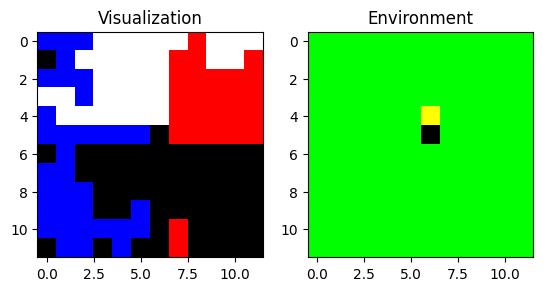

In [209]:
# visualize

q_pallete = np.array(
    [[0, 0, 0],         # black:0:Up
     [255, 0, 0],       # red:1:Left
     [255, 255, 255],   # white:2:Down
     [0, 0, 255]],      # blue:3:Right
     dtype=np.uint8)

Q_table_render_arr = make_3d(
    map_2d=Q_test.argmax(axis=1).reshape(
      tmp_env.observation_space.shape),
    palette_array=q_pallete)

O_render_arr = make_3d(
    map_2d=tmp_env.observation,
    palette_array=tmp_env.pallete)


plt.subplot(1,2,1)
plt.imshow(Q_table_render_arr)
plt.title('Visualization')
plt.subplot(1,2,2)
plt.imshow(O_render_arr)
plt.title('Environment')

plt.show()

### Task 5: Explain visual representation (Visualization picture on the left) after training

You can write your notes related to Task 5 here:

If the actor is to the right of the goal, it wants to go left (red)
If the actor is to the left of the goal, it wants to go right (blue)

If the actor is below, it wants to go up (black)
If the actor is above, it wants to go down (white)

There is one outlier, where the actor wants to go up, while still being above the goal (top left black square).
This might be because the actor has not encountered this spot that often as it is far from the starting position.


In [210]:
# close the environment
tmp_env.close()

image has more than 3 channels, only first 3 channels are used there are (12, 12, 4) channels


# 2️⃣ Assignment 2: Trondheim treasure hunt!


# 🐔 You are ready for the Trondheim challenge now 💪

*   Task 1: Initialize Q table
*   Task 2: Write necessary helper functions for Q-learning
*   Task 3: Play with Hyperparameters
*   Task 4: Train the agent using Q-learning


## **Important Note**: 
For Task 2, Task 3 and Task 4, you can (re)use the same code as in the Assignment 1.
**These are mentioned here as the elements of the pipeline.** 

Most of the code from Assigment 1 is reusable, we are just using it with different environment here.

In [323]:
# First and important - cleanup!
tmp_env.close()

image has more than 3 channels, only first 3 channels are used there are (32, 32, 4) channels


In [324]:
# let's configure the environment and see how it looks like
env_config = {
    'env_image_path':'input_images/image_TRD_2.png',
    'dead_allowed':False,
    'remove_after_location_found':True,
    'start_random':False,
    'number_removable_locations':1,
}

if not os.path.exists(env_config['env_image_path']):
  # make sure you have the folder and the image
  print(f"Error: The image path {env_config['env_image_path']} does not exist.")
else:
  # if everything fine, we create the environment
  tmp_env = TrondheimEnv(conf=env_config)
  print(f"Environment successfully created")

Environment successfully created


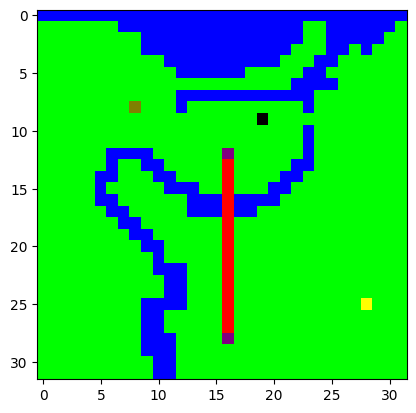

In [325]:
tmp_env.reset()
_ = tmp_env.render()

Next step towards: 
Green Land class area
-1


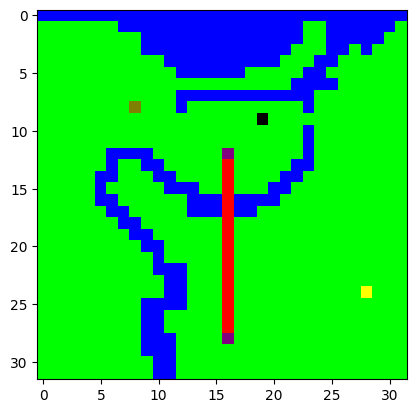

In [326]:
# select the action here
my_action = 'up'

# here is your action
obs, rew, term, info = tmp_env.step(action_dict[my_action])
print(rew)
_ = tmp_env.render()


### Task 1: Initialize Q table

In [327]:
# Task 1: Initialize Q table
"""
TODO: given the environment, initialize the Q table
"""

# Tip: pay attention to the dimensions of Q table
# Tip: how many states the table have, how many actions
# Extra tip:
"""number of states is different here in comparison with first example:
we have 2 subcases for this environment:
when Location is there and when it is removed/destroyed"""

print(f"Observation space dimensions:  {tmp_env.observation_space.shape}")
print(f"Number of possible actions: {tmp_env.action_space.n}")

num_states = 32*32*3
num_actions = 4
Q_test = np.zeros((num_states, num_actions))
print(Q_test.shape)

Observation space dimensions:  (32, 32)
Number of possible actions: 4
(3072, 4)


### Task 2: Write necessary helper functions for Q-learning

In [328]:
# Task 2: Write necessary helper functions for Q-learning
# Tip: just use the same helper functions you already implemented above
print()
# YOU DON'T NEED TO DO ANYTHING HERE. They are the same

### Task 3: Play with Hyperparameters

In [329]:
# Task 3: Play with Hyperparameters
# Tip - you can also use the same parameters as for the toy example above
# YOUR CODE GOES HERE (set the values below)

GAMMA_test = 0.9
NUM_EPISODES_test = 10000
MIN_EXPLORE_RATE_test = 0.01
MIN_LEARNING_RATE_test = 0.01
STEP_SIZE_TEST = 200
# Depending on your parameters for the toy environment, using the same parameters here could work fine
# if they are not working, you may want to set them to different values here

## Now use Q-learning to learn the Q table
### Task 4: Train the agent using Q-learning

  0%|          | 11/10000 [00:00<01:38, 101.57it/s]

Episode :0  Total_reward: -191  Explore rate: 1.0


 10%|█         | 1021/10000 [00:09<01:20, 111.53it/s]

Episode :1000  Total_reward: 19458  Explore rate: 0.3723720178604969


 20%|██        | 2016/10000 [00:18<01:10, 112.95it/s]

Episode :2000  Total_reward: 23277  Explore rate: 0.1426398781093821


 30%|███       | 3024/10000 [00:27<00:59, 116.59it/s]

Episode :3000  Total_reward: 24684  Explore rate: 0.058550485130572864


 40%|████      | 4020/10000 [00:35<00:51, 116.89it/s]

Episode :4000  Total_reward: 25288  Explore rate: 0.027771047742294684


 50%|█████     | 5016/10000 [00:44<00:42, 117.30it/s]

Episode :5000  Total_reward: 25086  Explore rate: 0.016504778211990458


 60%|██████    | 6012/10000 [00:52<00:34, 115.93it/s]

Episode :6000  Total_reward: 25287  Explore rate: 0.012380959198397956


 70%|███████   | 7020/10000 [01:01<00:25, 116.59it/s]

Episode :7000  Total_reward: 25689  Explore rate: 0.010871508069865636


 80%|████████  | 8016/10000 [01:09<00:17, 115.76it/s]

Episode :8000  Total_reward: 25689  Explore rate: 0.010319000139251432


 90%|█████████ | 9024/10000 [01:18<00:08, 117.42it/s]

Episode :9000  Total_reward: 25689  Explore rate: 0.010116764367836689


100%|██████████| 10000/10000 [01:26<00:00, 115.06it/s]


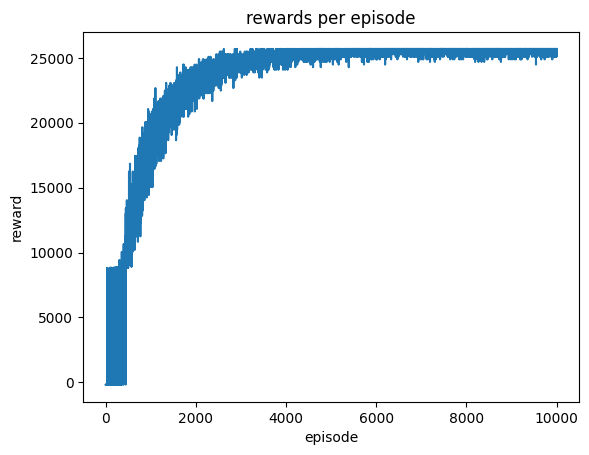

In [330]:
# Task 4: Train the agent using Q-learning
# Tip - you can use the same code (or function) as used for simple environment (Assignment 1 Task 4)
from tqdm import tqdm
# result of the training is:
#   updated Q table (Q_test)
#   total_reward
#   you are free to add others, if you will


tmp_env.manual_mode = False # disable printouts while training

# initialize some variables
Q_test = np.zeros((num_states, num_actions))
total_reward = 0
rewards_per_episode = []

for episode in tqdm(range(NUM_EPISODES_test)):
    explore_rate = update_explore_rate(episode, MIN_EXPLORE_RATE_test, 1, percentage_reduction=0.01)
    learning_rate = update_learning_rate(episode, MIN_LEARNING_RATE_test, base_lr=1, total_episodes=NUM_EPISODES_test)
    tmp_env.reset()
    state = tmp_env.get_1d_state()
    done = False
    reward_episode = 0

    for step in range(STEP_SIZE_TEST):
        if done:
            break

        action = update_action(tmp_env, state, explore_rate, Q_test)
        _, reward, done, _ = tmp_env.step(action)
        next_state = tmp_env.get_1d_state()
        reward_episode += reward
    
        best_next_action = np.argmax(Q_test[next_state])
        td_target = reward + GAMMA_test*Q_test[next_state][best_next_action]
        Q_test[state][action] = Q_test[state][action] + learning_rate*(td_target-Q_test[state][action])
        state = next_state

    rewards_per_episode.append(reward_episode)
    total_reward += reward_episode
  # Tip : print variables of interest, like episode, total_reward, explore_rate
    if (episode)%(NUM_EPISODES_test//10)==0:
        print(f"Episode :{episode}  Total_reward: {reward_episode}  Explore rate: {explore_rate}")

# print("Final Q values: ", Q_test)

plt.plot(rewards_per_episode)
plt.title("rewards per episode")
plt.xlabel("episode")
plt.ylabel("reward")
plt.show()

In [331]:
print(f"Total reward after training: {total_reward}, total Explore rate after training: {explore_rate}")

Total reward after training: 233004398, total Explore rate after training: 0.010043171247410658


## Let's see one episode

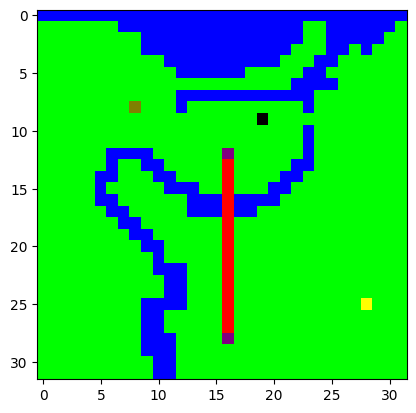

Next step towards: 
Green Land class area


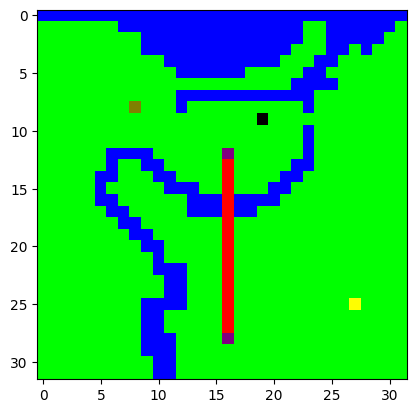

Next step towards: 
Green Land class area


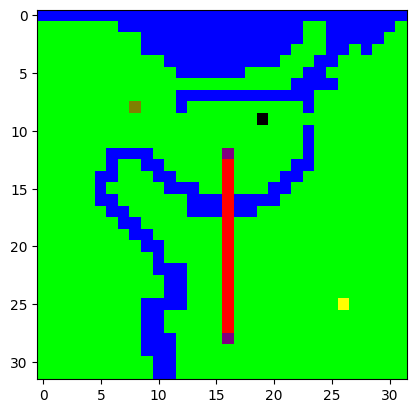

Next step towards: 
Green Land class area


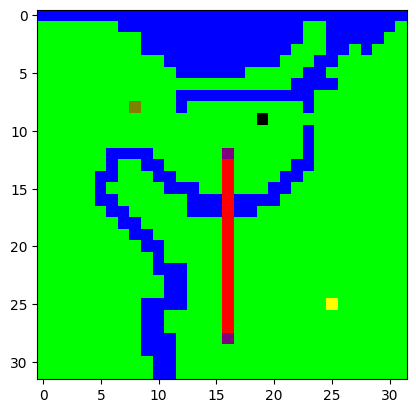

Next step towards: 
Green Land class area


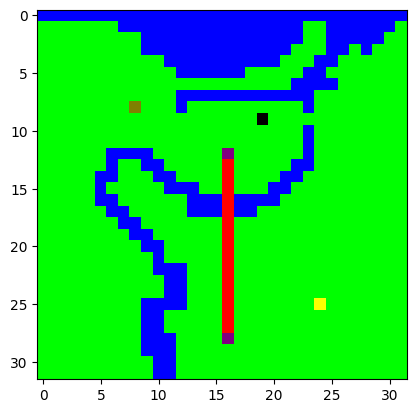

Next step towards: 
Green Land class area


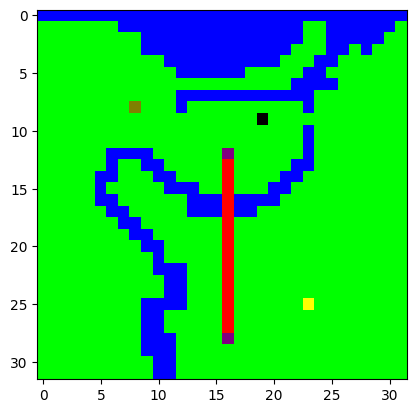

Next step towards: 
Green Land class area


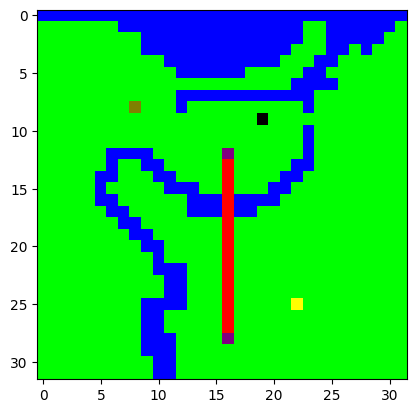

Next step towards: 
Green Land class area


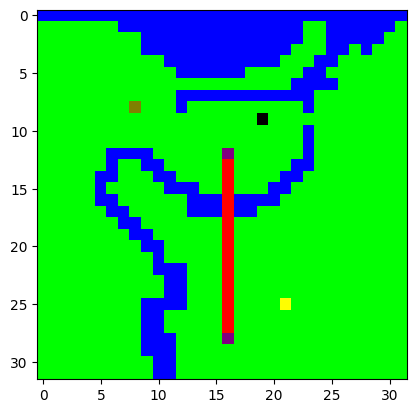

Next step towards: 
Green Land class area


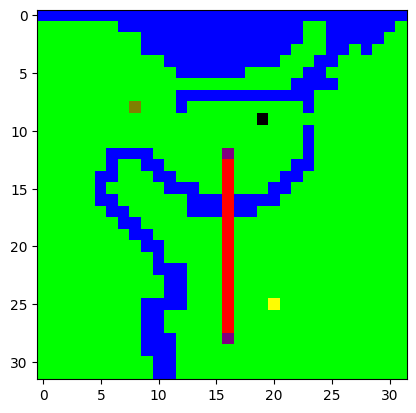

Next step towards: 
Green Land class area


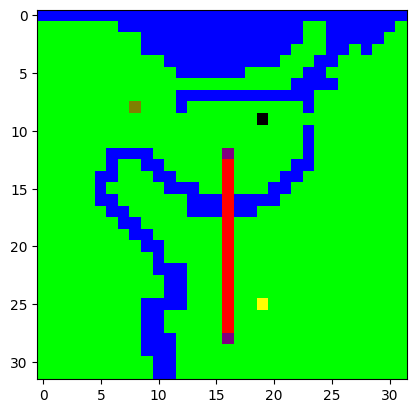

Next step towards: 
Green Land class area


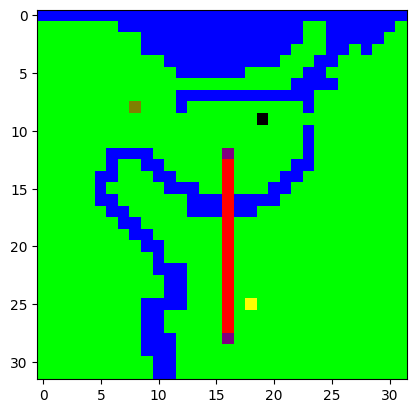

Next step towards: 
Green Land class area


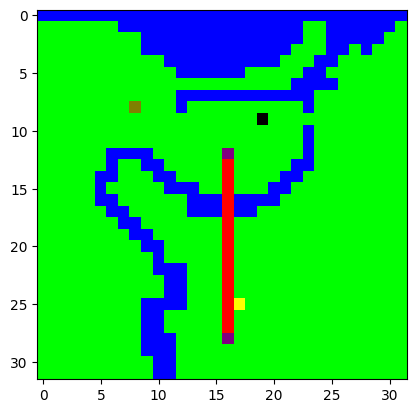

Next step towards: 


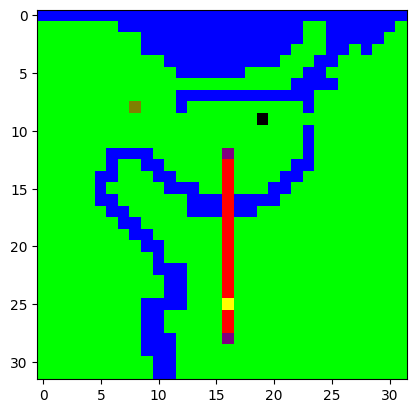

Next step towards: 


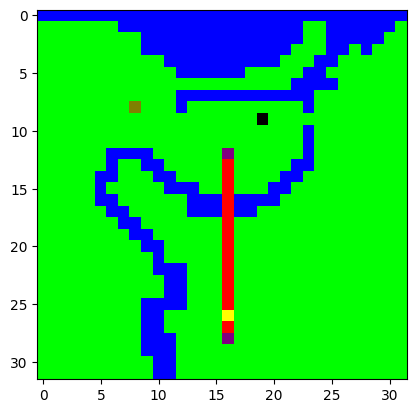

Next step towards: 


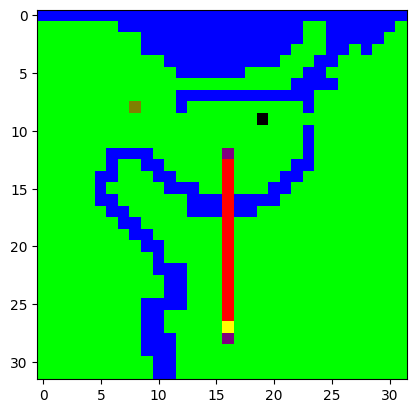

Next step towards: 
A bus stop


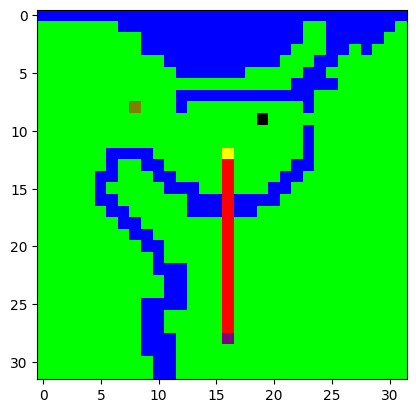

Next step towards: 
Green Land class area


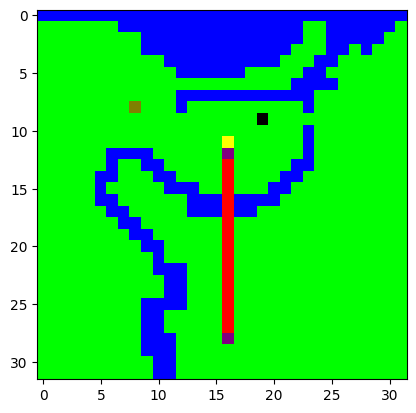

Next step towards: 
Green Land class area


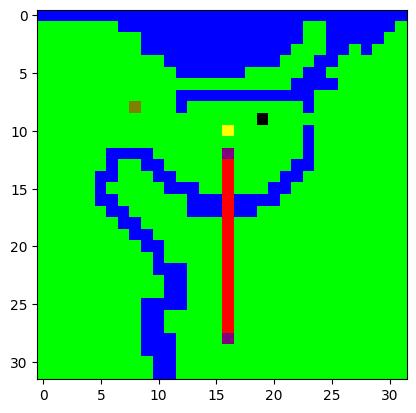

Next step towards: 
Green Land class area


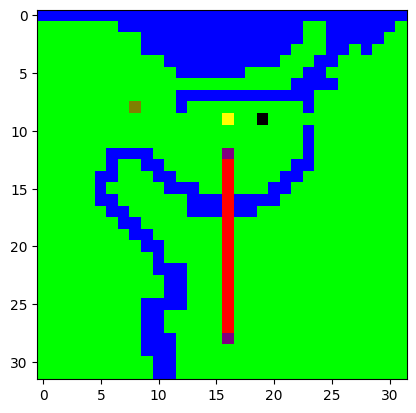

Next step towards: 
Green Land class area


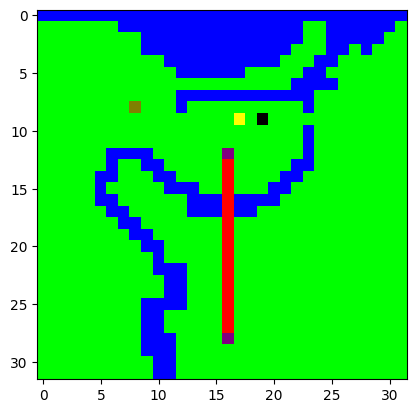

Next step towards: 
Green Land class area


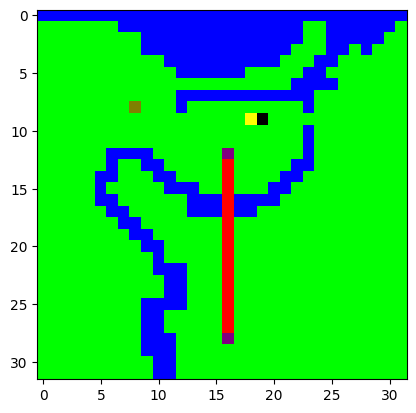

Next step towards: 
Central Source Secret Location


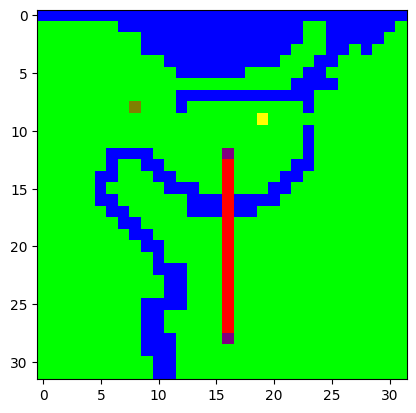

Next step towards: 
Green Land class area


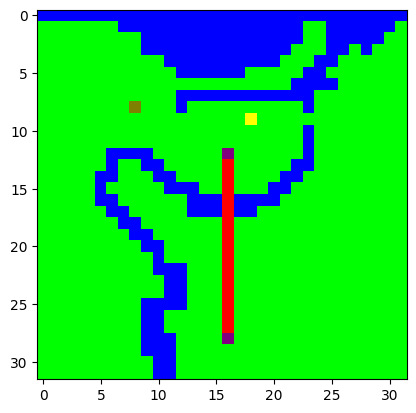

Next step towards: 
Green Land class area


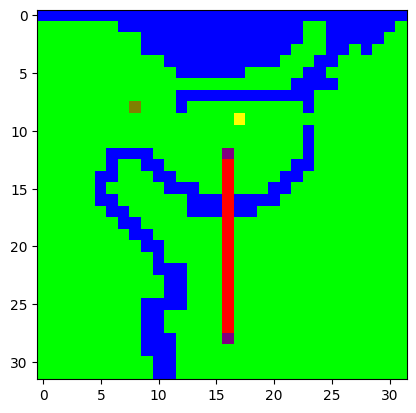

Next step towards: 
Green Land class area


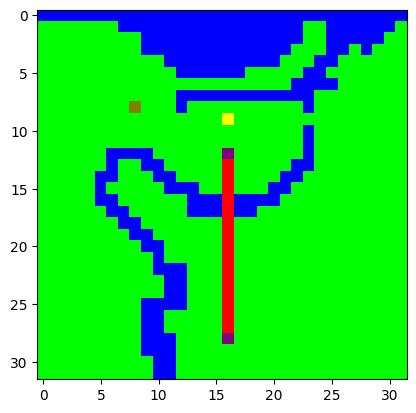

Next step towards: 
Green Land class area


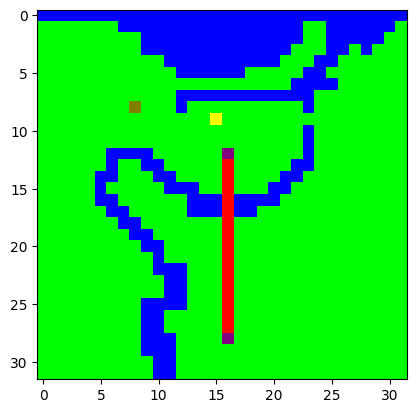

Next step towards: 
Green Land class area


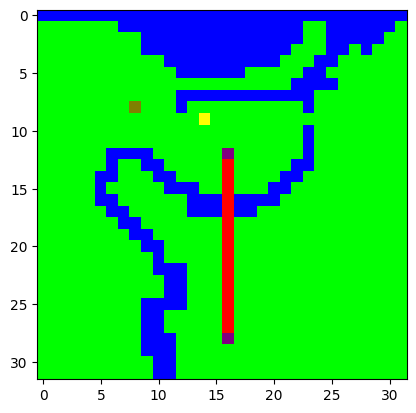

Next step towards: 
Green Land class area


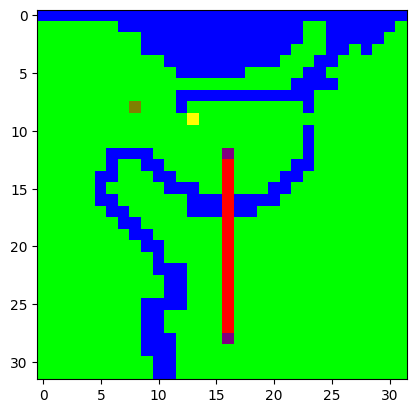

Next step towards: 
Green Land class area


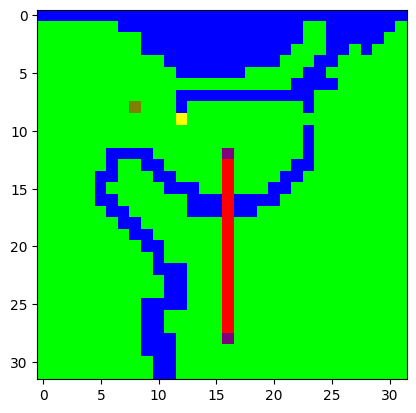

Next step towards: 
Green Land class area


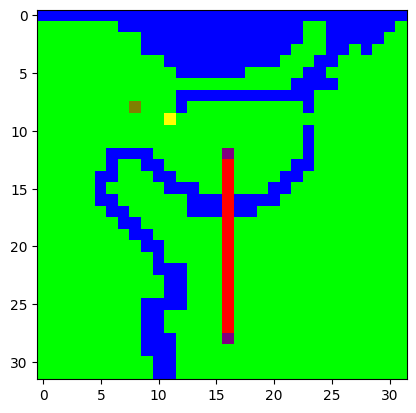

Next step towards: 
Green Land class area


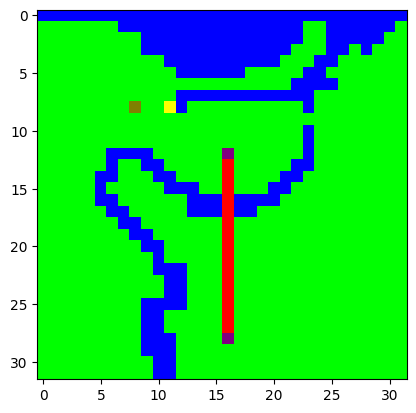

Next step towards: 
Green Land class area


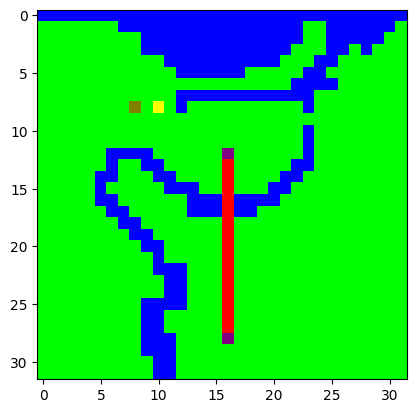

Next step towards: 
Green Land class area


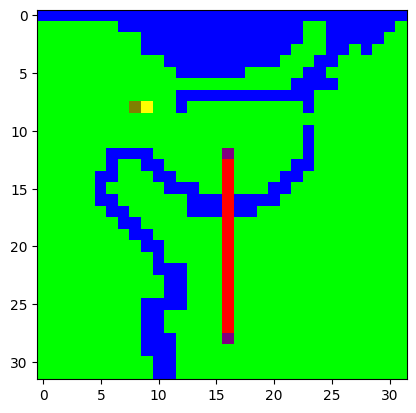

Next step towards: 
Final Location - well done!
You have discovered the Final Location of AI center in Trondheim


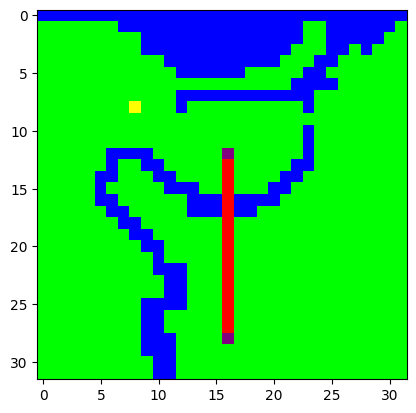

Next step towards: 
Green Land class area
Total_reward:  9172


In [340]:
#now we can show one episode

tmp_env.manual_mode = True # we want to see the messages
STEP_SIZE_TEST_test = 34

image_samples = []  # Array to store images

observation = tmp_env.reset()
state_0 = tmp_env.get_1d_state()
total_reward = 0

for _ in range(STEP_SIZE_TEST_test):
    img = tmp_env.render()
    image_samples.append(img)

    action = update_action(tmp_env, state_0, explore_rate, Q=Q_test)
    obv, reward, done, info = tmp_env.step(action)
    state_1 = tmp_env.get_1d_state()
    state_0 = state_1

    total_reward += reward

print(f"Total_reward: ", total_reward)
# self.observation.shape[0]

### Simple animation of agent movement in one episode

MovieWriter ffmpeg unavailable; using Pillow instead.


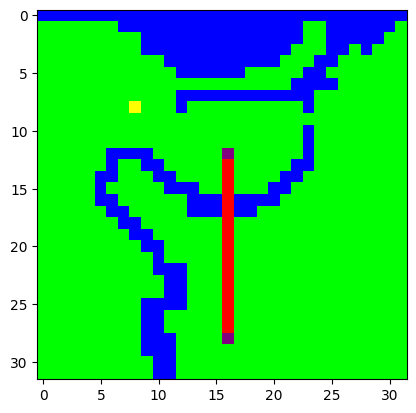

In [341]:
# let's make an animation of this, because it's fun
# nothing for you to do here - just run the code

import os
import matplotlib.animation as animation

height = img.shape[0]
width = img.shape[1]

output_folder = 'output_stuff'
if not os.path.exists(output_folder):
    os.makedirs(output_folder)


fig = plt.figure()
imgs = []
for i in range(STEP_SIZE_TEST_test):
    im = plt.imshow(image_samples[i].reshape(height, width, 3), animated=True)
    imgs.append([im])

animate = animation.ArtistAnimation(fig, imgs, interval=80, blit=True, repeat_delay=1000)
filename_gif = os.path.join(output_folder, 'animation_test.gif')
animate.save(filename_gif)
plt.show()